# Imports

In [25]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Simulate data

In [26]:
rng = np.random.default_rng(42)

mu1 = rng.normal(size=2)
mu2 = rng.normal(size=2)

p = 0.61
v1 = 0.4
v2 = 0.8

n_samples = 1000

# Draw 1000 samples from each Gaussian
samples1 = rng.multivariate_normal(mean=mu1, cov=np.diag([v1, v1]), size=n_samples)
samples2 = rng.multivariate_normal(mean=mu2, cov=np.diag([v2, v2]), size=n_samples)

# Choose 
which = rng.choice(2, p=[p, 1-p], size=n_samples)
samples = np.where(
    which[:, np.newaxis], 
    samples1, 
    samples2
)

(-5.0, 5.0)

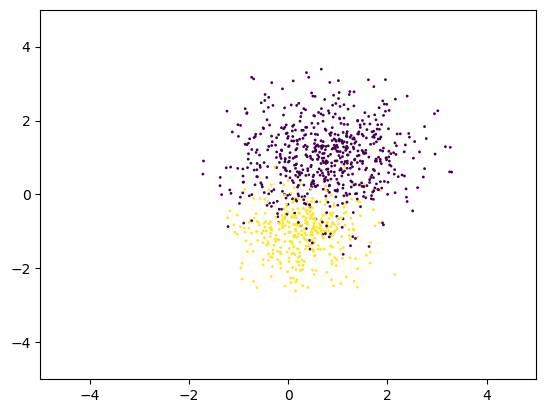

In [27]:
plt.scatter(
    samples[:,0],
    samples[:,1],
    s=1,
    c=which,
)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# EM

## Likelihood

In [28]:
def log_likelihood(
    samples,
    mu1_estimate,
    mu2_estimate,
    v1_estimate,
    v2_estimate,
    p_estimate,
):
    # Initialize random variable objects to calculate the pdf
    norm_rv1 = scipy.stats.multivariate_normal(mean=mu1_estimate, cov=np.diag([v1_estimate, v1_estimate]), seed=rng)
    norm_rv2 = scipy.stats.multivariate_normal(mean=mu2_estimate, cov=np.diag([v2_estimate, v2_estimate]), seed=rng)

    ll = 0.0
    for i in range(n_samples):
        likelihood_sample = (p_estimate * norm_rv1.pdf(samples[i, :]) + (1-p_estimate) * norm_rv2.pdf(samples[i, :]))
        ll += np.log(likelihood_sample)
        
    return ll
        
    

## Expectation step

In [29]:
def expectation_step(
    samples,
    mu1_estimate,
    mu2_estimate,
    v1_estimate,
    v2_estimate,
    p_estimate,
):
    # Initialize array to hold the posterior probability of a point coming from the Gaussians
    posterior_probs = np.zeros((n_samples, 2), dtype=float)
    
    # Initialize random variable objects to calculate the pdf
    norm_rv1 = scipy.stats.multivariate_normal(mean=mu1_estimate, cov=np.diag([v1_estimate, v1_estimate]), seed=rng)
    norm_rv2 = scipy.stats.multivariate_normal(mean=mu2_estimate, cov=np.diag([v2_estimate, v2_estimate]), seed=rng)
    
    # Calculate probabilities
    for i in range(n_samples):
        posterior_probs[i, 0] = p_estimate * norm_rv1.pdf(samples[i, :])
        posterior_probs[i, 1] = (1-p_estimate) * norm_rv2.pdf(samples[i, :])
        posterior_probs[i, :] /= posterior_probs[i, :].sum()
        
    return posterior_probs

## Maximization step

In [30]:
def maximization_step(
    samples,
    posterior_probs,
):
    # Re-estimate p
    p_estimate = posterior_probs[:, 0].mean()
    
    # Re-estimate the means
    mu1_estimate = np.dot(posterior_probs[:, 0], samples) / posterior_probs[:, 0].sum()
    mu2_estimate = np.dot(posterior_probs[:, 1], samples) / posterior_probs[:, 1].sum()
    
    # Re-estimate the variances
    v1_estimate = np.dot(posterior_probs[:, 0], ((samples - mu1_estimate[np.newaxis, :])**2).mean(axis=1)) / posterior_probs[:, 0].sum()
    v2_estimate = np.dot(posterior_probs[:, 1], ((samples - mu2_estimate[np.newaxis, :])**2).mean(axis=1)) / posterior_probs[:, 1].sum()
    
    return mu1_estimate, mu2_estimate, v1_estimate, v2_estimate, p_estimate


# EM

In [31]:
def expectation_maximization(
    samples,
    n_iterations,
    print_every=None,
):
    # Initialize
    mu1_estimate = rng.normal(size=2)
    mu2_estimate = rng.normal(size=2)
    v1_estimate = 1.0
    v2_estimate = 1.0
    p_estimate = 1.0 / 3.0      
    
    lls = []
    estimates = []
    all_posterior_probs = []
    for n_iter in range(n_iterations):
        ll = log_likelihood(
            samples,
            mu1_estimate,
            mu2_estimate,
            v1_estimate,
            v2_estimate,
            p_estimate,
        )
        lls.append(ll)
        if print_every is not None and n_iter % print_every == 0:
            print(f"Iteration {n_iter}: {ll}")
            
        # E-step
        posterior_probs = expectation_step(
            samples,
            mu1_estimate,
            mu2_estimate,
            v1_estimate,
            v2_estimate,
            p_estimate,
        )
        all_posterior_probs.append(posterior_probs)
        
        # M-step
        mu1_estimate, mu2_estimate, v1_estimate, v2_estimate, p_estimate = maximization_step(
            samples,
            posterior_probs,
        )
        estimates.append([mu1_estimate, mu2_estimate, v1_estimate, v2_estimate, p_estimate])
        
    return lls, estimates, all_posterior_probs
        
        
    
    


# Run it!

In [57]:
lls, estimates, all_posterior_probs = expectation_maximization(
    samples,
    50,
    print_every=10,
)
est=estimates[-1]
print (f"estimated mu1 ({est[0][0]},{est[0][1]}) mu2 ({est[1][0]},{est[1][1]}) v1 {est[2]} v2 {est[3]} p1 {est[4]}")

Iteration 0: -3905.043726858032
Iteration 10: -2810.3647165901507
Iteration 20: -2803.5134936140403
Iteration 30: -2803.4075991625905
Iteration 40: -2803.4057784402253
estimated mu1 (0.2745170140512419,-1.0120154618263417) mu2 (0.7771234384414566,1.0141435314013836) v1 0.3984988963536487 v2 0.7763061522682607 p1 0.37481644733598113


### Function to show estimates Gaussians

In [48]:
def draw_estimates(
    samples,
    mu1_estimate, 
    mu2_estimate, 
    v1_estimate, 
    v2_estimate,
    p1,
    post = None,
):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    if post is None:
        ax.scatter(samples[:,0], samples[:,1], s=1, alpha=0.5)
    else:
        ax.scatter(samples[:,0], samples[:,1], c=post, s=1, alpha=0.5)
    ax.plot(mu1_estimate[0], mu1_estimate[1], 'x', ms=10, color="red")
    ax.plot(mu2_estimate[0], mu2_estimate[1], 'x', ms=10, color="blue")
    ax.set_title(f"prior red {p1}")

    circle1 = plt.Circle(mu1_estimate, v1_estimate**0.5, color='red', fill=False)
    circle2 = plt.Circle(mu1_estimate, 2*v1_estimate**0.5, color='red', fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    circle3 = plt.Circle(mu2_estimate, v2_estimate**0.5, color='blue', fill=False)
    circle4 = plt.Circle(mu2_estimate, 2*v2_estimate**0.5, color='blue', fill=False)
    ax.add_patch(circle3)
    ax.add_patch(circle4)
    

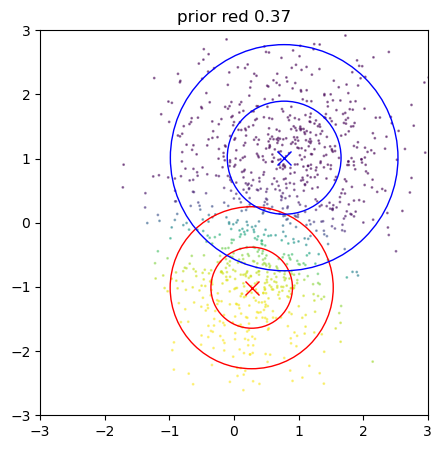

In [58]:
draw_estimates(
    samples,
    *estimates[-1][:-1],
    0.37,
    all_posterior_probs[40][:,0]
)

In [44]:
with open("gaussian_mixture.data",'w') as f:
    np.savetxt(f, samples, delimiter=' ', fmt='%.4f')
    f.close()